In [1184]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import norm
from sklearn.metrics import r2_score

In [1185]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_august.csv", sep=",")

In [1186]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
0,1/31/2008,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
1,2/29/2008,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
2,3/31/2008,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,...,0.0,NaN,0.0,NaN,2.6,0.000,NaN,5.25,0.000000,NaN
3,4/30/2008,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,...,0.0,NaN,0.0,NaN,2.7,0.033,NaN,5.31,0.020000,NaN
4,5/31/2008,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,...,0.0,NaN,0.0,NaN,2.8,0.067,NaN,5.50,0.083333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.25,-0.083333,-0.041667
211,8/31/2025,26.9,15.2,21.7,6.3,6.2,4.4,4.6,3.8,6.0,...,0.0,0.0,0.0,0.0,4.0,0.000,0.000000,4.25,-0.083333,-0.041667


In [1187]:
ex_future=df[df['Ap'].isna()][['Mnd',
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
        'Rodt_skandale_lag6',
        'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
        #'Frp_reg_lag6','SV_reg_lag6', 
        #'SP_reg_lag6','KrF_reg_lag6',
        #'Venstre_reg_lag6', 
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']]

In [1188]:
ex_future
ex_future["Mnd"] = pd.to_datetime(df["Mnd"])
ex_future.set_index("Mnd", inplace=True)

In [1189]:
df.dropna(inplace=True)

In [1190]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
5,6/30/2008,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
6,7/31/2008,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
7,8/31/2008,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
8,9/30/2008,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
9,10/31/2008,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,4/30/2025,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.25,-0.083333,-0.041667


In [1191]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [1192]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [1193]:
df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,0.0,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
2025-06-30,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,4.5,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000


In [1194]:
df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df_en = df_en.diff().dropna()  # Difference to make stationary
df_orig=df

In [1195]:
df_ex=df[[
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
       #'Venstre_skandale_lag6', 
        #'MDG_skandale_lag6', 
       'Rodt_skandale_lag6',
       #'Andre_skandale_lag6', 
       # 'Ap_reg', 'Hoyre_reg', 'Frp_reg', 'SV_reg',
       #'SP_reg', 'KrF_reg', 'Venstre_reg', 'MDG_reg', 'Rodt_reg', 'Andre_reg',
       #'Ap_reg_lag3', 
       'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
       # 'Frp_reg_lag6','SV_reg_lag6', 
       # 'SP_reg_lag6','KrF_reg_lag6',
       # 'Venstre_reg_lag6', 
        #'MDG_reg_lag6',
        #'Rodt_reg_lag6', 
        #'Andre_reg_lag6',
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']].iloc[1:]

In [1196]:
df_ex

,Ap_skandale_lag6,Hoyre_skandale_lag6,Frp_skandale_lag6,SV_skandale_lag6,SP_skandale_lag6,KrF_skandale_lag6,Rodt_skandale_lag6,Ap_reg_lag6,Hoyre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,
2008-07-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
2008-11-30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.000,0.033333,4.75,-0.333333,-0.131667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
2025-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
2025-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000


In [1197]:
#model = VARMAX(endog=df_en, exog=df_ex, order=(6,0), trend='c')
#model_fitted = model.fit(disp=False)

#print(model_fitted.summary())

In [1198]:
#model = VAR(endog=df_en, exog=df_ex)
model = VAR(endog=df_en)

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [1199]:
model_fitted = model.fit(maxlags=2,method = 'ols', trend='n', verbose=True)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Aug, 2025
Time:                     14:28:41
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -9.89088
Nobs:                     204.000    HQIC:                  -11.8280
Log likelihood:          -1353.95    FPE:                1.96971e-06
AIC:                     -13.1439    Det(Omega_mle):     7.73079e-07
--------------------------------------------------------------------
Results for equation Ap
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
L1.Ap             -1.525598         0.403066           -3.785           0.000
L1.Hoyre          -1.562254         0.402715           -3.879           0.000
L1.Frp            -1.585969         0.398975           -3.975           0.0

In [1200]:
# Compute R² for each party
r2_scores = {}
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']:
    r2_scores[party] = r2_score(df_en[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.1787
R² for Hoyre: 0.1500
R² for Frp: 0.1047
R² for SV: 0.1954
R² for SP: 0.0678
R² for KrF: 0.3520
R² for Venstre: 0.2499
R² for MDG: 0.1631
R² for Rodt: 0.1521
R² for Andre: 0.1978


In [1129]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [1130]:
all_fitted= model_fitted.fittedvalues

In [1131]:
all_fitted

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-09-30,0.872480,-0.873647,-0.508435,0.173048,-0.162482,0.451900,-0.187701,0.070231,-0.059348,0.015025
2008-10-31,0.550977,-0.329186,-0.218585,0.372731,-0.051753,0.093559,-0.031289,0.019721,-0.288464,-0.109767
2008-11-30,0.990791,0.245794,-0.677594,-0.199278,-0.450918,0.293605,0.137667,-0.134329,-0.353613,-0.049009
2008-12-31,0.304626,0.820073,0.116173,-0.024676,-0.269875,-0.450037,-0.264217,-0.071123,-0.242248,-0.380410
2009-01-31,2.872212,-1.012800,-1.125737,-0.069577,-0.507782,-0.024509,0.077865,-0.055249,-0.310965,-0.044403
...,...,...,...,...,...,...,...,...,...,...
2025-04-30,-0.276132,0.096940,-1.071146,-0.084973,0.473620,0.449314,0.095749,0.087989,0.179760,0.039047
2025-05-31,0.388102,-1.197287,0.628483,0.415745,-0.068632,-0.018757,0.132729,-0.175714,0.201838,-0.175104
2025-06-30,1.208450,-1.143325,0.508522,-0.639354,-0.132276,0.061339,-0.164281,0.294525,-0.149110,0.057069


In [1132]:
steps = 1  # Number of steps to forecast
alpha = 0.1

forecast, lower, upper = model_fitted.forecast_interval(df_en.values[-model_fitted.k_ar:],  exog_future=ex_future, steps=steps, alpha=alpha)


In [1133]:
forecast

array([[-0.18591285, -0.36800481,  0.45347078,  0.68859359,  0.53950574,
        -0.75961791, -0.08856302,  0.0192249 ,  0.40225467, -0.7190843 ]])

In [1134]:
forecast_dates = pd.date_range(start="2025-09-30", periods=steps, freq='ME')

last_actual_value = df_orig.iloc[-1]  # Last known actual data point

forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en.columns)
forecast_lower_df=pd.DataFrame(lower, index=forecast_dates, columns=df_en.columns)
forecast_upper_df=pd.DataFrame(upper, index=forecast_dates, columns=df_en.columns)

forecast_df = forecast_df.cumsum() + last_actual_value
forecast_lower_df = forecast_lower_df.cumsum() + last_actual_value
forecast_upper_df = forecast_upper_df.cumsum() + last_actual_value

In [1135]:
# Get forecast covariance in differenced scale
forecast_cov = model_fitted.forecast_cov(steps=steps)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov[t] = np.sum(forecast_cov[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_df = {t: pd.DataFrame(forecast_cov[t], index=df_en.columns, columns=df_en.columns)
                            for t in range(steps)}

In [1136]:
df_en=df_orig

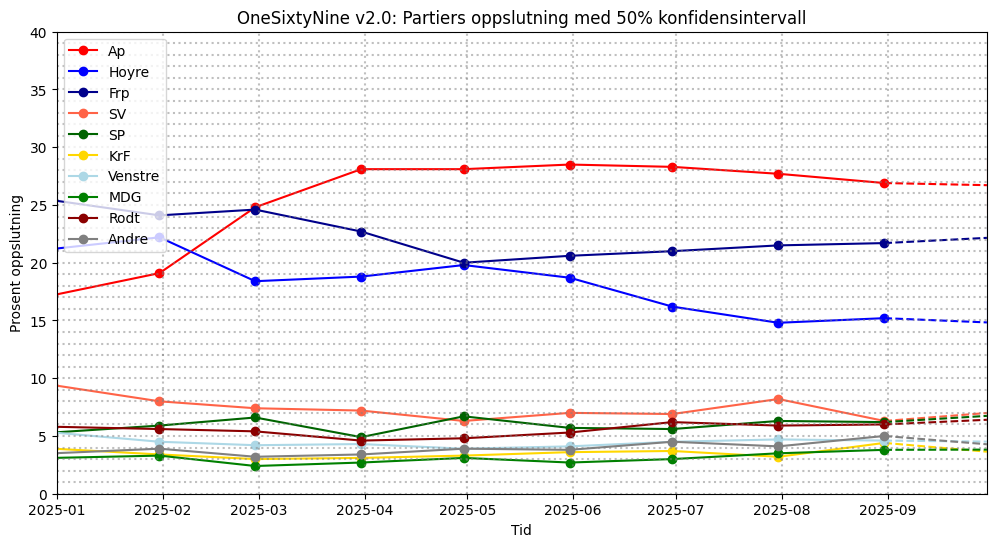

In [1137]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df_en.index, df_en[party], marker="o", color=color, label=f"{party}")

    # Plot forecast 
    plt.plot(forecast_df.index, forecast_df[party], linestyle="dashed", color=color)

    last_actual_date = df_en.index[-1]
    first_forecast_date = forecast_df.index[0]
    last_actual_value = df_en[party].iloc[-1]
    first_forecast_value = forecast_df[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_df.index, 
                     forecast_lower_df[party], 
                     forecast_upper_df[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS") 
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2025-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v2.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [1138]:
forecast_df=forecast_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
#forecast_df=(forecast_df.T / forecast_df.sum(axis=1) * 100).T
forecast_lower_df=forecast_lower_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_upper_df=forecast_upper_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]

In [1139]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_df.loc[date_to_extract]
lower_row = forecast_lower_df.loc[date_to_extract]
upper_row = forecast_upper_df.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
result_df

,Party,Estimate,Lower,Upper
0,Ap,26.714087,24.346810,29.081364
1,Hoyre,14.831995,12.849953,16.814037
2,Frp,22.153471,20.292450,24.014491
3,SV,6.988594,6.242100,7.735087
4,SP,6.739506,5.252677,8.226335
5,KrF,3.640382,3.075438,4.205326
6,Venstre,4.511437,3.856005,5.166869
7,MDG,3.819225,3.265368,4.373082
8,Rodt,6.402255,5.684441,7.120068
9,Andre,4.280916,3.644205,4.917626


In [1162]:
# Multivariate MC!
n_sim = 1000000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
yhat_vector = df_orig.iloc[-1][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].values
cov_matrix = forecast_cov[-1]  # Covariance matrix at final step (latest forecast)
#cov_matrix = df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].cov()#.to_numpy()
#cov_matrix=cov_matrix_df.to_numpy()

# Convert to NumPy array
#W = cov_matrix.to_numpy()

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
#samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)# /sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)# /sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.8757


In [1141]:
cov_matrix

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Ap,33.503505,-5.946079,3.642902,-9.299127,-7.828528,3.753157,0.398944,-3.412622,-9.431440,-6.424631
Hoyre,-5.946079,20.106494,-9.219892,-1.503323,-3.685965,-0.569148,0.084277,-0.023797,1.037589,1.584504
Frp,3.642902,-9.219892,24.467680,-0.135679,-10.617298,1.989319,1.613095,-6.569903,-4.133074,-3.188524
SV,-9.299127,-1.503323,-0.135679,3.692891,2.493516,-1.094001,0.001813,0.933484,2.916294,1.906718
SP,-7.828528,-3.685965,-10.617298,2.493516,15.727430,-1.982381,-2.327038,4.348482,3.296618,1.167623
KrF,3.753157,-0.569148,1.989319,-1.094001,-1.982381,0.793735,0.314867,-0.955908,-1.571909,-0.995672
Venstre,0.398944,0.084277,1.613095,0.001813,-2.327038,0.314867,0.646028,-0.548074,-0.355227,0.010945
MDG,-3.412622,-0.023797,-6.569903,0.933484,4.348482,-0.955908,-0.548074,3.182543,2.195453,1.477558
Rodt,-9.431440,1.037589,-4.133074,2.916294,3.296618,-1.571909,-0.355227,2.195453,4.080097,2.614191
Andre,-6.424631,1.584504,-3.188524,1.906718,1.167623,-0.995672,0.010945,1.477558,2.614191,2.372264


In [1142]:
df_orig.iloc[-1][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].values

array([26.9, 15.2, 21.7,  6.3,  6.2,  4.4,  4.6,  3.8,  6. ,  5. ])

In [1143]:
df_orig_p=df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]

In [1144]:
df_orig_p

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2
...,...,...,...,...,...,...,...,...,...
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3
2025-06-30,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2


In [1145]:
sampled_df.drop(columns=["Andre"], inplace=True)

In [1163]:
yhat_vector

array([26.9, 15.2, 21.7,  6.3,  6.2,  4.4,  4.6,  3.8,  6. ,  5. ])

In [1172]:
orig_mandate=pd.DataFrame(columns=df_orig.columns)

In [1146]:
sample_mandate=pd.DataFrame(columns=sampled_df.columns)

In [1147]:
def calc_mandat(oppslutt):
    if oppslutt <4.0:
        mandat=np.round(1/4*oppslutt**2,0)
    else: 
        oppslutt=round(1.8119*oppslutt,0)
    return int(oppslutt)

In [1148]:
for party in sampled_df.columns:
    sample_mandate[party]=sampled_df[party].apply(calc_mandat)

In [1177]:
for party in df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]:
    orig_mandate[party]=df_orig[party].apply(calc_mandat)

In [1180]:
orig_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,47,32,52,13,10,11,11,0,1,0,...,0,0,0,0,2,0,0,10,0,0
2008-07-31,49,31,55,12,9,11,10,0,1,0,...,0,0,0,0,2,0,0,10,0,0
2008-08-31,48,29,56,12,9,10,11,0,1,0,...,0,0,0,0,3,0,0,10,0,0
2008-09-30,52,28,54,11,9,10,11,0,1,0,...,0,0,0,0,3,0,0,10,0,0
2008-10-31,55,29,48,13,10,10,10,0,1,0,...,0,0,0,0,3,0,0,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,51,36,36,11,12,3,3,3,9,3,...,0,0,0,0,7,0,0,8,0,0
2025-05-31,52,34,37,13,10,3,7,2,10,3,...,0,0,0,0,7,0,0,8,0,0
2025-06-30,51,29,38,13,10,3,8,3,11,8,...,0,0,0,0,7,0,0,8,0,0


In [1149]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
0,44,24,50,14,9,7,10,1,12
1,48,26,36,13,18,3,3,8,12
2,57,34,43,9,11,9,3,0,2
3,74,24,31,2,18,9,3,8,2
4,54,18,46,11,14,3,8,3,8
...,...,...,...,...,...,...,...,...,...
999995,40,26,34,17,18,3,9,10,13
999996,40,26,45,17,10,3,9,2,13
999997,50,13,57,11,11,3,7,7,11
999998,48,26,34,11,14,3,8,11,13


In [1150]:
import numpy as np
import pandas as pd

W = cov_matrix.to_numpy()[:9, :9]  # must be a numpy array
#W = cov_matrix[:9, :9]
party_cols = ['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']
X = sample_mandate[party_cols].to_numpy()
one_vec = np.ones(len(party_cols))
W_inv = np.linalg.inv(W)

target_sum = 169
X_adj = []

for row in X:
    diff = target_sum - row.sum()
    # GLS adjustment (float)
    lambda_ = diff / (one_vec @ W_inv @ one_vec)
    adj_row = row + W_inv @ one_vec * lambda_

    # Convert to integers using largest remainder
    int_row = np.floor(adj_row).astype(int)
    remainder = int_row.sum()
    deficit = target_sum - remainder

    # Distribute remaining seats to largest fractional parts
    frac = adj_row - np.floor(adj_row)
    for i in np.argsort(-frac)[:deficit]:
        int_row[i] += 1

    X_adj.append(int_row)

# Replace with adjusted integer values
df_adj = sample_mandate.copy()
df_adj[party_cols] = X_adj
df_adj['Sum_adj'] = df_adj[party_cols].sum(axis=1)

#print(df_adj[['Sum_adj']].head())


In [1151]:
sample_169=df_adj

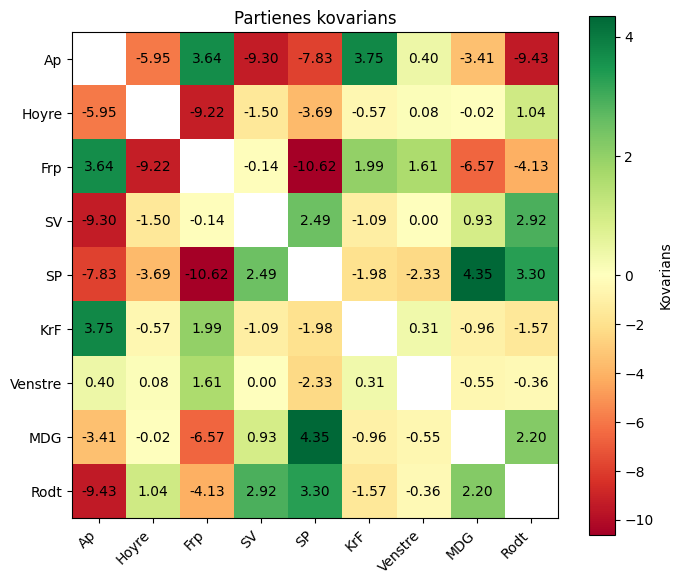

In [1152]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Party labels
labels = ['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']

# Mask diagonal to hide color
W_masked = W.copy()
np.fill_diagonal(W_masked, np.nan)

# Normalize colormap to center at zero
norm = mcolors.TwoSlopeNorm(vmin=np.nanmin(W_masked), vcenter=0, vmax=np.nanmax(W_masked))

plt.figure(figsize=(7, 6))
im = plt.imshow(W_masked, cmap='RdYlGn', norm=norm)
plt.colorbar(im, label='Kovarians')
plt.title('Partienes kovarians')

# Add numerical values for non-diagonal cells
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        if i != j:
            plt.text(j, i, f"{W[i, j]:.2f}", ha='center', va='center', color='black')

# Set axis ticks and labels
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

plt.grid(False)
plt.tight_layout()
plt.show()


In [1153]:
sample_169['rg'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)

In [1154]:
sample_169['bb'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)

In [1155]:
sample_169

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum_adj,rg,bb
0,44,24,50,13,9,7,9,1,12,169,79,90
1,48,26,36,14,18,3,4,8,12,169,100,69
2,57,34,43,10,11,9,3,0,2,169,80,89
3,74,24,31,1,18,9,2,8,2,169,103,66
4,54,18,46,12,14,4,9,3,9,169,92,77
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,40,26,34,16,18,3,9,10,13,169,97,72
999996,40,26,45,18,10,4,10,2,14,169,84,85
999997,50,13,57,10,11,3,7,7,11,169,89,80
999998,48,26,34,12,14,3,8,11,13,169,98,71


In [1156]:
sample_169['r_win'] = (sample_169['bb'] < sample_169['rg'])

In [1157]:
sample_169['r_win'].mean()

0.668236

In [1160]:
filtered = sample_169[(sample_169['MDG'] < 4) & (sample_169['KrF'] > 4) & (sample_169['Venstre'] > 4)]

# Calculate probability
prob = filtered['r_win'].mean()

print(f"Probability: {prob:.4f}")
print(f"Number of cases: {len(filtered)}")

Probability: 0.2679
Number of cases: 245801


In [1159]:
len(sample_169[sample_169['Rodt'] < 5])

116978

In [757]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)

In [758]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)
sample_169['ap_sp'] = sample_169[["Ap", "SP"]].sum(axis=1)
sample_169['ap_sp_sv'] = sample_169[["Ap", "SP", "SV"]].sum(axis=1)
sample_169['ap_sp_sv_r'] = sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)
sample_169['ap_sp_sv_r_mdg'] = sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)
sample_169['h_frp'] = sample_169[["Hoyre", "Frp"]].sum(axis=1)
sample_169['h_frp_v_krf'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)
sample_169['h_frp_v_krf_mdg'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF", "MDG"]].sum(axis=1)

In [759]:
sample_169['red_green_victory'] = sample_169['red_green'] >= 85
sample_169['ap_sp_victory'] = sample_169['ap_sp'] >= 85
sample_169['ap_sp_sv_victory'] = sample_169['ap_sp_sv'] >= 85
sample_169['ap_sp_sv_r'] = sample_169['ap_sp_sv_r'] >= 85
sample_169['ap_sp_sv_r_mdg'] = sample_169['ap_sp_sv_r_mdg'] >= 85
sample_169['h_frp'] = sample_169['h_frp'] >= 85
sample_169['h_frp_v_krf'] = sample_169['h_frp_v_krf'] >= 85
sample_169['h_frp_v_krf_mdg'] = sample_169['h_frp_v_krf_mdg'] >= 85

In [760]:
sample_169['r_avh'] = (sample_169['ap_sp_sv'] < 85) & (sample_169['ap_sp_sv_r']) >= 85

In [761]:
print(sample_169['red_green_victory'].mean())
print(sample_169['ap_sp_victory'].mean())
print(sample_169['ap_sp_sv_victory'].mean())
print(sample_169['ap_sp_sv_r'].mean())
print(sample_169['ap_sp_sv_r_mdg'].mean())
print(sample_169['h_frp'].mean())
print(sample_169['h_frp_v_krf'].mean())
print(sample_169['h_frp_v_krf_mdg'].mean())
print(sample_169['r_avh'].mean())

0.9541145132185719
0.0
9.54754198531588e-06
0.5019715674199677
0.9541145132185719
0.0
0.04588548678142812
0.49802843258003227
0.0


In [762]:
sample_169.to_csv('sample.csv')

In [763]:
len(sample_169['rg'])

104739

In [764]:
np.round(sample_169['rg'])

0         93
7         91
10        93
14        87
19        89
          ..
999983    95
999986    88
999989    93
999992    86
999996    87
Name: rg, Length: 104739, dtype: int64

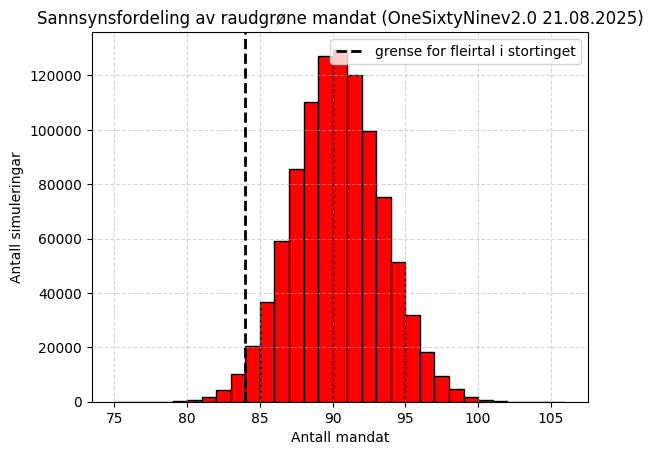

In [1026]:

plt.hist(
    sample_169['rg'],
    bins=range(75, sample_169['rg'].max() + 2),
    edgecolor='black',
    color='red'       # Set bar color to red
)
plt.axvline(
    x=84,
    color='black',
    linestyle='--',
    linewidth=2,
    label='grense for fleirtal i stortinget' # Optional label
)
plt.title('Sannsynsfordeling av raudgrøne mandat (OneSixtyNinev2.0 21.08.2025)')
plt.xlabel('Antall mandat')
plt.ylabel('Antall simuleringar')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [766]:
last_actual_value

5.0

In [767]:
last_fact=df_orig[df_orig.index=='2025-08-31'][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]

In [768]:
last_fact

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2025-08-31,26.9,15.2,21.7,6.3,6.2,4.4,4.6,3.8,6.0


In [769]:
last_mandate=pd.DataFrame(columns=last_fact.columns)

In [770]:
for party in last_fact.columns:
    last_mandate[party]=last_fact[party].apply(calc_mandat)

In [771]:
last_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2025-08-31,49,28,39,11,11,8,8,3,11


In [772]:
last_mandate['Sum']=last_mandate.sum(axis=1)

In [773]:
last_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
Mnd,,,,,,,,,,
2025-08-31,49,28,39,11,11,8,8,3,11,168


In [774]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
2025-09-30,26.714087,14.831995,22.153471,6.988594,6.739506,3.640382,4.511437,3.819225,6.402255,4.280916


In [775]:
forecast_df['Sum']=forecast_df.sum(axis=1)

In [776]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,Sum
2025-09-30,26.714087,14.831995,22.153471,6.988594,6.739506,3.640382,4.511437,3.819225,6.402255,4.280916,100.081867


In [777]:
cov_matrix

array([[ 2.07130361e+00, -6.19768646e-01, -5.99054919e-01,
        -1.44424930e-01, -3.16330182e-01, -4.24720978e-02,
        -1.31096831e-01, -6.80952707e-02, -1.58890035e-01,
         1.64059473e-02],
       [-6.19768646e-01,  1.45201496e+00, -3.44883190e-01,
        -5.67064180e-02, -2.38493120e-01, -6.18235456e-02,
        -1.05471315e-02, -7.09371842e-02, -2.62884485e-02,
        -1.73305237e-02],
       [-5.99054919e-01, -3.44883190e-01,  1.28011124e+00,
        -2.75425393e-02, -1.20086105e-01, -1.59917127e-02,
        -5.46932162e-02,  8.60135576e-03, -3.90694908e-02,
        -7.85724986e-02],
       [-1.44424930e-01, -5.67064180e-02, -2.75425393e-02,
         2.05966914e-01, -2.48317983e-02,  1.50149840e-02,
         1.66244973e-02,  3.39681356e-03,  9.03295563e-03,
         1.73717657e-03],
       [-3.16330182e-01, -2.38493120e-01, -1.20086105e-01,
        -2.48317983e-02,  8.17085421e-01, -4.95466475e-02,
        -2.35513140e-02, -6.83012424e-03,  6.00494005e-02,
        -8.

In [778]:
forecast

array([[-0.18591285, -0.36800481,  0.45347078,  0.68859359,  0.53950574,
        -0.75961791, -0.08856302,  0.0192249 ,  0.40225467, -0.7190843 ]])

In [779]:
import numpy as np
from scipy.optimize import minimize

# example: estimates
parties = [c for c in forecast_df.columns if c != "Sum"]
e = forecast_df.loc["2025-09-30", parties].values


# weight matrix (identity for simple case)
W = cov_matrix

def objective(p):
    diff = p - e
    return diff @ W @ diff  # quadratic form

cons = [{'type': 'eq', 'fun': lambda p: np.sum(p) - 100}]
bounds = [(0, None)] * len(e)

res = minimize(objective, e, constraints=cons, bounds=bounds)
p_adj = res.x
print(p_adj)

[26.70590045 14.8238085  22.14528409  6.98040692  6.73131906  3.63219542
  4.50325031  3.81103823  6.394068    4.27272903]


In [780]:
p_adj

array([26.70590045, 14.8238085 , 22.14528409,  6.98040692,  6.73131906,
        3.63219542,  4.50325031,  3.81103823,  6.394068  ,  4.27272903])

In [781]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# --- Original data ---
data = {
    "Party": ["Ap","Hoyre","Frp","SV","SP","KrF","Venstre","MDG","Rodt","Andre"],
    "Estimate": [26.714087,14.831995,22.153471,6.988594,6.739506,
                 3.640382,4.511437,3.819225,6.402255,4.280916],
    "Lower": [24.346810,12.849953,20.292450,6.242100,5.252677,
              3.075438,3.856005,3.265368,5.684441,3.644205],
    "Upper": [29.081364,16.814037,24.014491,7.735087,8.226335,
              4.205326,5.166869,4.373082,7.120068,4.917626]
}
df = pd.DataFrame(data)

# --- adjustment function ---
def adjust_to_100(x):
    W = np.eye(len(x))  # simple equal weighting

    def objective(p):
        diff = p - x
        return diff @ W @ diff

    cons = [{'type': 'eq', 'fun': lambda p: np.sum(p) - 100}]
    bounds = [(0, None)] * len(x)

    res = minimize(objective, x, constraints=cons, bounds=bounds)
    return res.x

# --- Adjust all three columns ---
df["Estimate_adj"] = adjust_to_100(df["Estimate"].values)
df["Lower_adj"]    = adjust_to_100(df["Lower"].values)
df["Upper_adj"]    = adjust_to_100(df["Upper"].values)

# --- Sanity check sums ---
print("Original sums:", df[["Estimate","Lower","Upper"]].sum())
print("Adjusted sums:", df[["Estimate_adj","Lower_adj","Upper_adj"]].sum())

print(df)


Original sums: Estimate    100.081868
Lower        88.509447
Upper       111.654285
dtype: float64
Adjusted sums: Estimate_adj    100.0
Lower_adj       100.0
Upper_adj       100.0
dtype: float64
     Party   Estimate      Lower      Upper  Estimate_adj  Lower_adj  \
0       Ap  26.714087  24.346810  29.081364     26.705900  25.495865   
1    Hoyre  14.831995  12.849953  16.814037     14.823808  13.999008   
2      Frp  22.153471  20.292450  24.014491     22.145284  21.441505   
3       SV   6.988594   6.242100   7.735087      6.980407   7.391155   
4       SP   6.739506   5.252677   8.226335      6.731319   6.401732   
5      KrF   3.640382   3.075438   4.205326      3.632195   4.224493   
6  Venstre   4.511437   3.856005   5.166869      4.503250   5.005060   
7      MDG   3.819225   3.265368   4.373082      3.811038   4.414423   
8     Rodt   6.402255   5.684441   7.120068      6.394068   6.833496   
9    Andre   4.280916   3.644205   4.917626      4.272729   4.793260   

   Upper_adj

In [782]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Data
df = pd.DataFrame({
    'Party': ['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre'],
    'Estimate': [26.714087,14.831995,22.153471,6.988594,6.739506,3.640382,4.511437,3.819225,6.402255,4.280916],
    'Lower': [24.346810,12.849953,20.292450,6.242100,5.252677,3.075438,3.856005,3.265368,5.684441,3.644205],
    'Upper': [29.081364,16.814037,24.014491,7.735087,8.226335,4.205326,5.166869,4.373082,7.120068,4.917626]
})

# Covariance matrix
W = cov_matrix
W_inv = np.linalg.inv(W)

def adjust_column(orig):
    """Minimize Mahalanobis distance subject to sum=100"""
    def objective(x):
        delta = x - orig
        return delta @ W_inv @ delta
    constraint = {'type': 'eq', 'fun': lambda x: x.sum() - 100}
    res = minimize(objective, orig, constraints=constraint)
    return res.x

# Apply to each column
df['Estimate_adj'] = adjust_column(df['Estimate'].values)
df['Lower_adj'] = adjust_column(df['Lower'].values)
df['Upper_adj'] = adjust_column(df['Upper'].values)

# Check sums
print(df[['Estimate_adj','Lower_adj','Upper_adj']].sum())
print(df)


Estimate_adj    100.0
Lower_adj       100.0
Upper_adj       100.0
dtype: float64
     Party   Estimate      Lower      Upper  Estimate_adj  Lower_adj  \
0       Ap  26.714087  24.346810  29.081364     26.705453  25.572023   
1    Hoyre  14.831995  12.849953  16.814037     14.826095  13.696778   
2      Frp  22.153471  20.292450  24.014491     22.143564  21.718526   
3       SV   6.988594   6.242100   7.735087      6.990564   5.961968   
4       SP   6.739506   5.252677   8.226335      6.726868   6.972232   
5      KrF   3.640382   3.075438   4.205326      3.637144   3.530496   
6  Venstre   4.511437   3.856005   5.166869      4.521865   2.388333   
7      MDG   3.819225   3.265368   4.373082      3.813976   4.001999   
8     Rodt   6.402255   5.684441   7.120068      6.380317   8.755101   
9    Andre   4.280916   3.644205   4.917626      4.254154   7.402546   

   Upper_adj  
0  27.838697  
1  15.955137  
2  22.568106  
3   8.019210  
4   6.482276  
5   3.743784  
6   6.655454  
7   3.

In [783]:
df

,Party,Estimate,Lower,Upper,Estimate_adj,Lower_adj,Upper_adj
0,Ap,26.714087,24.346810,29.081364,26.705453,25.572023,27.838697
1,Hoyre,14.831995,12.849953,16.814037,14.826095,13.696778,15.955137
2,Frp,22.153471,20.292450,24.014491,22.143564,21.718526,22.568106
3,SV,6.988594,6.242100,7.735087,6.990564,5.961968,8.019210
4,SP,6.739506,5.252677,8.226335,6.726868,6.972232,6.482276
5,KrF,3.640382,3.075438,4.205326,3.637144,3.530496,3.743784
6,Venstre,4.511437,3.856005,5.166869,4.521865,2.388333,6.655454
7,MDG,3.819225,3.265368,4.373082,3.813976,4.001999,3.625953
8,Rodt,6.402255,5.684441,7.120068,6.380317,8.755101,4.005653
9,Andre,4.280916,3.644205,4.917626,4.254154,7.402546,1.105731
